# Hypotenuse AI
## Artificial Idiocy

Given the lengths of two sides of a right triangle we will find out the length of the hypotenuse - using (drum rolls please) Artificial Intelligence!

In [1]:
import sys
import os

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.model_LR import train_linear_model, cross_validate_model
from hypotai.plotting import plot_regression_surface

from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
df = generate_triangle_data(n_samples=100_000, angle_mode="right")         # < ------ Right triangle data
df_random = generate_triangle_data(n_samples=100_000, angle_mode="random") # < ------ Random triangle data
df_random.head()

,a,b,angle_deg,c
0,77.418209,93.893436,72.857543,102.588822
1,43.943956,94.767465,70.738430,90.357018
2,85.873932,53.647085,155.505630,136.517008
3,69.767066,25.161402,103.815503,79.617355
4,9.508317,73.958379,136.270380,81.095974


## Train a linear regression model with the given lengths

So here, we give the two sides a, and b. Then we "train" our linear regression model to learn how it can find the "c". i.e. the Hypotenus. 

Normally, the c as a function of a and b is a surface ($c^2=a^2+b^2$) but it could have been any other surface defined by two parameters. Our "machine learning algorithm" treats this as a two-unknown linear equation with an ansatz like; $ĉ = w₀ + w₁·a + w₂·b$ so it literally says; if I scale $a$ and scale $b$ then add something constant I should be able to find $c$.

Then by looking at the $a,b,c$ pairs we give, it lowers and increases these _weights_ and _biases_ until the $ĉ$ they give starts to look like the $c$ we give. Once it likes the coefficients, it freezes them. So the next time there is an $a,b$ pair it knows what to multiply and add them to get to the correct $c$.

In [3]:
modelLR, metricsLR = train_linear_model(df)

In [4]:
modelLR 

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
## Here are the intercept and the coeff
# i.e. the $w_0$ and $w_1, w_2$ in the linear regression equation
print("Intercept:", modelLR.intercept_)
print("Coefficients:", modelLR.coef_)

Intercept: 8.330238922910866
Coefficients: [0.68148382 0.68128574]


In [6]:
metricsLR

{'mse': 38.992631125627746, 'r2': 0.9517649740572465}

The metrics are the things we define to assess "how good" we approached to the solution. Here, the MSE (Mean squared error) is average square differences between the true and the predicted value. i.e. if the c was 5, and we predicted 5.5 it is (5.5-5)^2=25 (and average over all values).

It makes more sense to talk about RMSE (root-MSE) in our case this would be $\sqrt(38.9)=6.24$ which means on average we are off by 6.24 units. Which is actually bad. 

R^2 test is more about the **variance** (oh I love talking about variance) 
it tells you how much of the variance in the target is explained by the model, ie. if it is **0** it means your model is as good as just predicting the mean value of all c values. If it is **1** then you are predicting it perfectly. If it is **<0** then you are doing something wrong. A bit more technically (thanks to chatGPT);


$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

where $y_i$ are true values, $\hat{y}_i$ are predicted values, and the $\bar{y}$ mean of true values. So the nominator is the residual sum of squares, and the denominator is the total sum of squares. 

What it really tells, how different the differences between true-predicted values is from the just predicting the mean of all true values. 
Because, if your best guess is worse than just predicting the mean (i.e. R2<0) why bother.

In [7]:
## Make some test data
df_test = generate_triangle_data(n_samples=10_000, angle_mode="right")
X_test, y_test = df_test[["a", "b"]], df_test["c"]
y_pred = modelLR.predict(X_test)

/home/karamel/projects/HypotAI/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


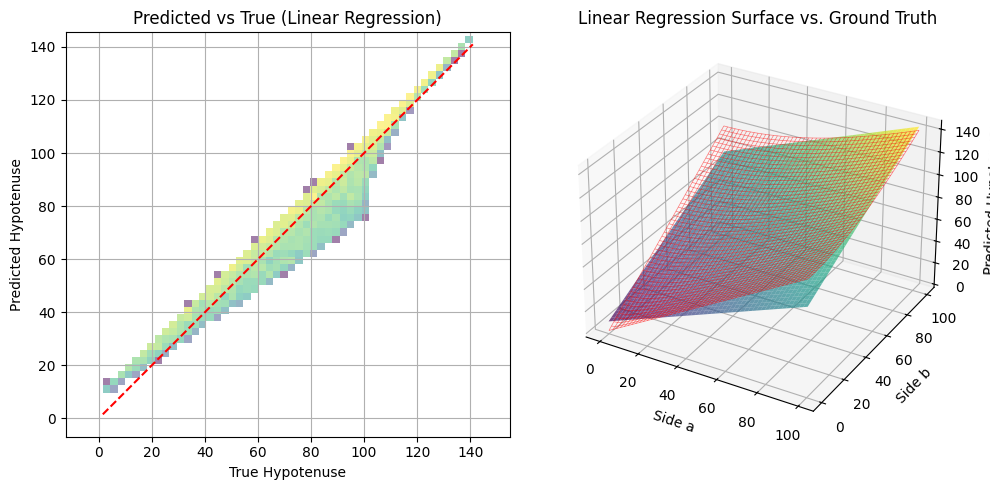

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.hist2d(y_test, y_pred, bins=(50,50), alpha=0.5, norm=LogNorm())
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_xlabel("True Hypotenuse")
ax1.set_ylabel("Predicted Hypotenuse")
ax1.set_title("Predicted vs True (Linear Regression)")
ax1.grid(True)
ax1.axis("equal")
plot_regression_surface(modelLR, ax=ax2)
plt.show()

### Why is it not a perfect fit? 

The reason is, our surface is not actually a linear surface is it? It is the quadratic sum of the two sides. So a linear model alone can only do so much. 

The colored actual 3D surface on the plot is adjusted so that most of the values still match but it is not perfect. 

We could get fancier.

### What if the angle was also random. 

Instead of all triangles being right triangles, what if (for now) training data had **only the right triangles** but we tested them on also on other types of triangles.   

In [9]:
## Make some test data
df_test_random = generate_triangle_data(n_samples=30_000, angle_mode="random")
X_test2, y_test2 = df_test_random[["a", "b"]], df_test_random["c"]
y_pred2 = modelLR.predict(X_test2)

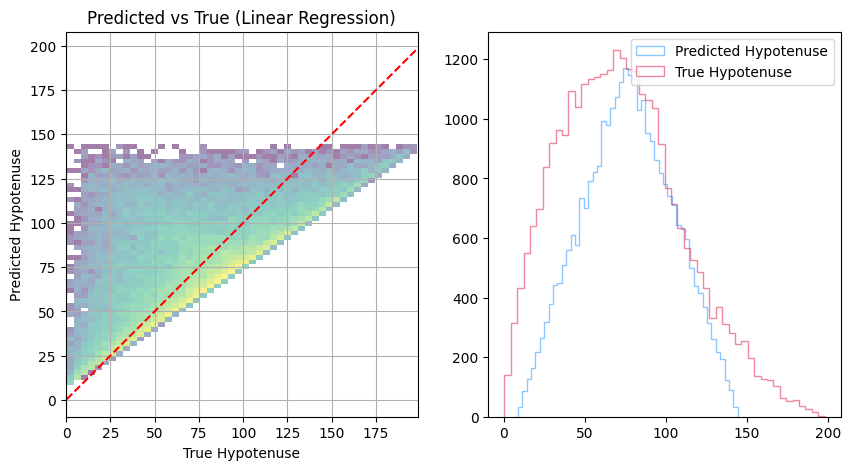

In [10]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist2d(y_test2, y_pred2, bins=(50,50), alpha=0.5, norm=LogNorm())
ax1.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--')
ax1.set_xlabel("True Hypotenuse")
ax1.set_ylabel("Predicted Hypotenuse")
ax1.set_title("Predicted vs True (Linear Regression)")
ax1.grid(True)
ax1.axis("equal")
# plot_regression_surface(modelLR, ax=ax2) ## it is the same surface as before
ax2.hist(y_pred2, bins=50, alpha=0.5, label="Predicted Hypotenuse", histtype='step', color='dodgerblue')
ax2.hist(y_test2, bins=50, alpha=0.5, label="True Hypotenuse", histtype='step', color='crimson')
ax2.legend()
plt.show()

As expected this time the predictions are a little worse. We could improve this if had shown the "training set" some data with non-right angle triangles. 

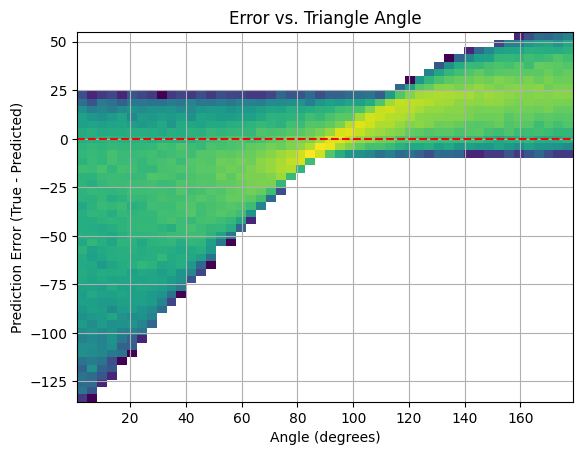

In [15]:
errors = df_random["c"] - modelLR.predict(df_random[["a", "b"]])

plt.hist2d(df_random["angle_deg"], errors, bins=(50,50), norm=LogNorm(), alpha=1)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Angle (degrees)")
plt.ylabel("Prediction Error (True - Predicted)")
plt.title("Error vs. Triangle Angle")
plt.grid(True)
plt.show()

This is also expected right? Your **model** knows only 90-degree triangles, but when you give triangles of all sorts, it does the best job around 90 degree and gets worse on different angles.

#### Train on all types

Let's quickly train on all types and check the behaviour.

In [16]:
modelLR_angles, metricsLR_angles = train_linear_model(df_random)
metricsLR_angles

{'mse': 784.1267063625083, 'r2': 0.4466877244249343}

it is much worse. The reason is we only provide the two sides and no angle information. So the model sees the same two sides e.g. 3,4 but each time (depending on the unkown angle) the true "c" is always different. So it gets super confused. 

We could train also by giving the angles. Then we look into more "complex" models.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_random[["a", "b", "angle_deg"]] ## the same data, but now we include the angle
y = df_random["c"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelLR_angles2 = LinearRegression()
modelLR_angles2.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_pred = modelLR_angles2.predict(X_test)

metrics = {"mse": mean_squared_error(y_test, y_pred),
            "r2": r2_score(y_test, y_pred)}
metrics

{'mse': 305.0439729152105, 'r2': 0.7847483404982469}

So the MSE is almost half the previous value -> meaning that on average we are closer to the true values. Let's visualize.

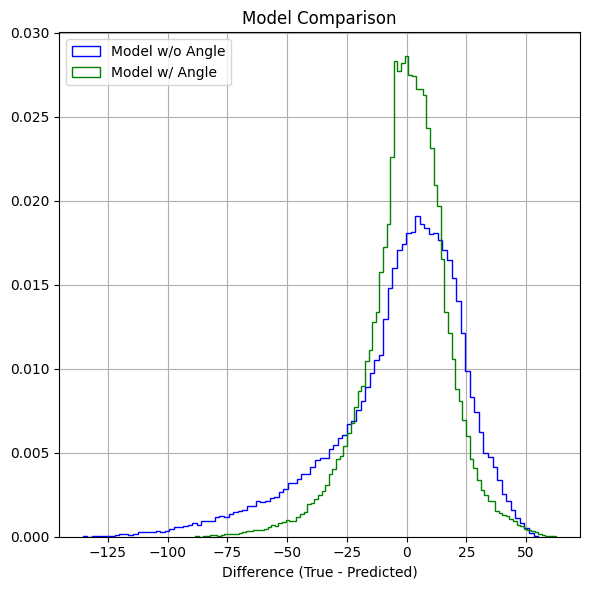

In [34]:
new_data = generate_triangle_data(n_samples=100_000, angle_mode="random")
X_new = new_data[["a", "b", "angle_deg"]]
y_new = new_data["c"]

y_pred_base = modelLR.predict(X_new[["a", "b"]])   # model without angle
y_pred_full = modelLR_angles2.predict(X_new)        # model with angle


plt.figure(figsize=(6, 6))
plt.hist(y_new-y_pred_base, bins=100, histtype="step", label="Model w/o Angle", color="blue", density=True)
plt.hist(y_new-y_pred_full, bins=100, histtype="step", label="Model w/ Angle", color="green", density=True)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Difference (True - Predicted)")
plt.title("Model Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

So this is what the "Linear Regression" models do. They fit a linear line i.e. no higher powers or anything like that. Simple linear coefficients and some bias. In one-dimensional data this is fitting a line $y=mx+b$ and in 2D it is the surface $\sqrt{a^2+b$2}$, if you have a huge dataset with 15 features, it is still the same thing, just harder to visualize. 